In [2]:
!pip install matplotlib

In [3]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)  # 随机生成K个0～1的数,作为拉动每根拉杆的获奖概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未
        # 获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [19]:
class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # TODO: 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        # Q* = max E(r), Regret = Q* - Q(a)
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

# $\epsilon$-greedy

A modified version of totally greedy algorithm.

The next action is given by
$
    a = 
    \begin{cases}
    \arg \max_{a'} \hat{Q}(a' \in \mathcal{A}) & \text{sampling rate } 1-\epsilon \\
    \text{random select from } \mathcal{A} & \text{sampling rate } \epsilon \\
    \end{cases}
$

In [66]:
class EpsilonGreedy(Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0, alpha=None):
        super(EpsilonGreedy, self).__init__(bandit)
        # TODO: init eposilon solver
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.alpha = alpha # step size in SMA, better to set when you are facing a nonstationary problem

    def get_best_est(self):
        return np.argmax(self.estimates)

    def run_one_step(self):
        # TODO: do one step
        # get a choice
        choice = -1
        if np.random.rand() > self.epsilon:
            choice = self.get_best_est()
        else:
            choice = np.random.randint(0, self.bandit.K)
        
        # update estimates
        r = self.bandit.step(choice)
        update_rate = self.alpha if self.alpha is not None else self.counts[choice]+1
        self.estimates[choice] += (r - self.estimates[choice])/update_rate

        return choice

epsilon-贪婪算法的累积懊悔为： 25.526630933945313
epsilon-贪婪算法的累积懊悔为： 219.82536054154974
epsilon-贪婪算法的累积懊悔为： 1834.2178747310413
epsilon-贪婪算法的累积懊悔为： 1714.1177827298031
epsilon-贪婪算法的累积懊悔为： 1941.3023683755284
epsilon-贪婪算法的累积懊悔为： 3144.9808024224144


/var/folders/pb/f5kv730d7_j57wxqp_92dwhh0000gp/T/ipykernel_68242/141851417.py:25: RuntimeWarning: overflow encountered in scalar divide
  self.estimates[choice] += (r - self.estimates[choice])/update_rate
/var/folders/pb/f5kv730d7_j57wxqp_92dwhh0000gp/T/ipykernel_68242/141851417.py:25: RuntimeWarning: invalid value encountered in scalar add
  self.estimates[choice] += (r - self.estimates[choice])/update_rate


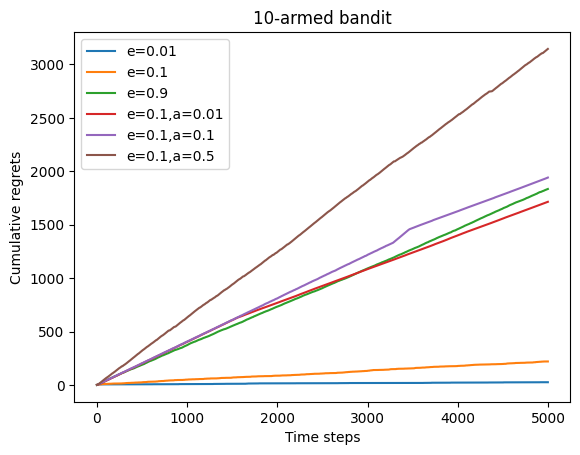

In [67]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()


np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver2 = EpsilonGreedy(bandit_10_arm, epsilon=0.1)
epsilon_greedy_solver3 = EpsilonGreedy(bandit_10_arm, epsilon=0.9)
epsilon_greedy_solver4 = EpsilonGreedy(bandit_10_arm, epsilon=0.1, alpha=0.01)
epsilon_greedy_solver5 = EpsilonGreedy(bandit_10_arm, epsilon=0.1, alpha=0.1)
epsilon_greedy_solver6 = EpsilonGreedy(bandit_10_arm, epsilon=0.1, alpha=0.9)
solvers = [epsilon_greedy_solver, epsilon_greedy_solver2, epsilon_greedy_solver3, epsilon_greedy_solver4, epsilon_greedy_solver5, epsilon_greedy_solver6]
for s in solvers:
    s.run(5000)
    print('epsilon-贪婪算法的累积懊悔为：', s.regret)
plot_results(solvers, ["e=0.01", "e=0.1", "e=0.9", "e=0.1,a=0.01", "e=0.1,a=0.1", "e=0.1,a=0.5"])

# Decaying $\epsilon$-Greedy

Same as $\epsilon$-Greedy, except now we have $\epsilon_t = \frac{1}{t}$.

In [96]:
class DecayEpsilonGreedy(Solver):
    """decay epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0, alpha=None):
        super(DecayEpsilonGreedy, self).__init__(bandit)
        # TODO: init eposilon solver
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.alpha = alpha # step size in SMA, better to set when you are facing a nonstationary problem

    def get_best_est(self):
        return np.argmax(self.estimates)

    def run_one_step(self):
        # TODO: do one step
        # get a choice
        choice = -1
        if np.random.rand() > 1 / (len(self.actions)+1):
            choice = self.get_best_est()
        else:
            choice = np.random.randint(0, self.bandit.K)
        
        # update estimates
        r = self.bandit.step(choice)
        update_rate = self.alpha if self.alpha is not None else self.counts[choice]+1
        self.estimates[choice] += 1.0 / update_rate * (r - self.estimates[choice])

        return choice

decay epsilon-贪婪算法的累积懊悔为： 109.25768072116382
decay epsilon-贪婪算法的累积懊悔为： 1002.4732432798003
decay epsilon-贪婪算法的累积懊悔为： 9160.21382036183
decay epsilon-贪婪算法的累积懊悔为： 7993.318983483413


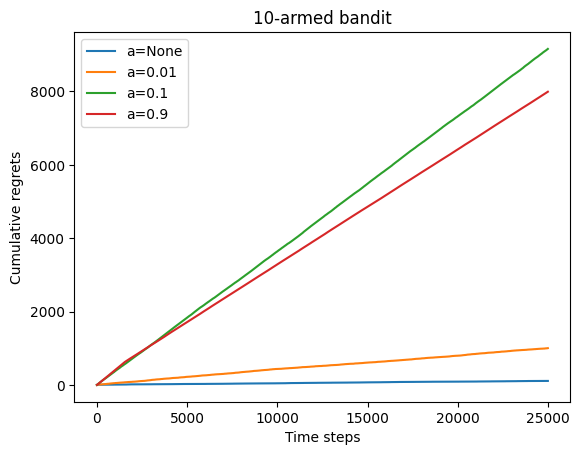

In [97]:
decay_epsilon_greedy_solver = DecayEpsilonGreedy(bandit_10_arm)
decay_epsilon_greedy_solver2 = DecayEpsilonGreedy(bandit_10_arm, alpha=0.01)
decay_epsilon_greedy_solver3 = DecayEpsilonGreedy(bandit_10_arm, alpha=0.1)
decay_epsilon_greedy_solver4 = DecayEpsilonGreedy(bandit_10_arm, alpha=0.9)
solvers = [epsilon_greedy_solver, epsilon_greedy_solver2, epsilon_greedy_solver3, epsilon_greedy_solver4]
for s in solvers:
    s.run(5000)
    print('decay epsilon-贪婪算法的累积懊悔为：', s.regret)
plot_results(solvers, ["a=None", "a=0.01", "a=0.1", "a=0.9",])

# Upper Bound Confidence (UBC)

It comes from Hoeffding's inequality. Let ${X_1, X_2, ..., X_n}$ to be n i.i.d. random variables whose ranges are all [0, 1], and the experience expectation $\bar{x}_n = \frac{1}{n}\sum_{j=1}^{n} X_j$, then we have: $$\mathbb{P}\{\mathbb{E}[x] \geq \bar{x}_n + u\} \leq e^{-2nu^2},$$ where $u$ is a measure of uncertainty.

Think about the Bandit problem. We have $K$ i.i.d random variables, and our goal is to maximize the expected reward $Q_t(a)$. We can use $u = \hat{U}_t(a)$ to denote the uncertainty of the action at time $t$, and $\hat{Q}_t{a}$ is out observed expectation. Let $N_t(a)$ denote the times of action $a$ being chosen at time $t$. Plug in the formula, we have $$Q_t(a) \geq \hat{Q}_t(a) + \hat{U}_t(a) \leq e^{-2N_t(a)\hat{U}_t(a)^2}. $$

We know that when $p=e^{-2N_t(a)\hat{U}_t(a)^2}$ is small enough, $Q_t(a) \leq \hat{Q}_t(a) + \hat{U}_t(a)$ will hold in a large probability (be aware of the reverse of the inequality here!), and that we can estimate $Q_t(a)$ by its Upper Bound $UB = \hat{Q}_t(a) + \hat{U}_t(a)$. Therefore, we can choose the action that maximize $UB$ to maximize $Q_t(a)$, namely $a = \arg \max_{a'}(\hat{Q}_t(a) + \hat{U}_t(a))$

So what is $\hat{U}_t(a)$? Solving $p=e^{-2N_t(a)\hat{U}_t(a)^2}$ gives us $\hat{U}_t(a)=\sqrt{\frac{-\log p}{2N_t(a)}}$. Hence, for a designated small $p$, we have a decision strategy: $$a = \arg \max_{a'}(\hat{Q}_t(a) + \sqrt{\frac{-\log p}{2N_t(a)}}).$$

In our implementation, we set $p=\frac{1}{t}$ and add a coefficient $c$ on the uncertainty. Thus we have: $$a = \arg \max_{a'}(\hat{Q}_t(a) + c\sqrt{\frac{\log t}{2N_t(a)}}).$$

That is our Upper Bound Confidence (UBC) policy.

上置信界算法的累积懊悔为： 2028.4759282935008


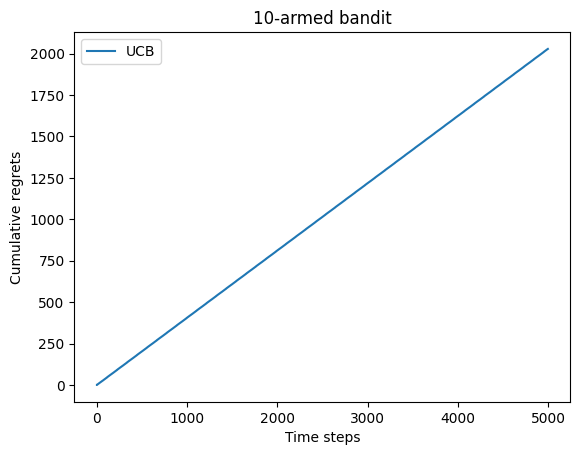

In [148]:
class UCBSolver(Solver):
    def __init__(self, bandit, init_prob=1, c=1):
        super(UCBSolver, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.c = c
        self.total_count = 0  # renamed from t for clarity

    def get_best_est(self):
        ucb = self.estimates + self.c * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))
        return np.argmax(ucb)

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.c * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k
np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCBSolver(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

上置信界算法的累积懊悔为： 70.45281214197854


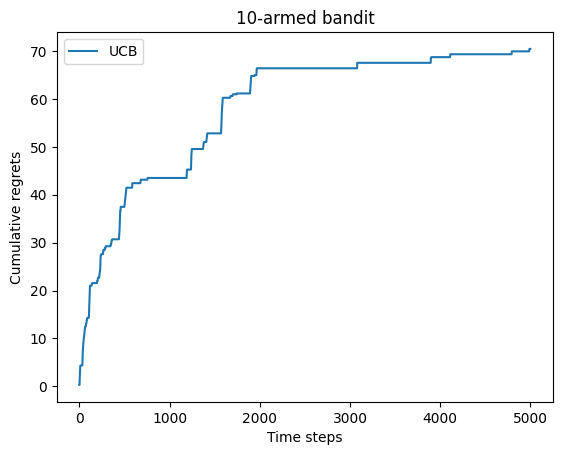

In [ ]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def get_best_est(self):
        ucb = self.estimates + self.coef * np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))
        return np.argmax(ucb)

    def run_one_step(self):
        self.total_count += 1
        choice = self.get_best_est()

        r = self.bandit.step(choice)
        self.estimates[choice] += 1. / (self.counts[choice] + 1) * (r - self.estimates[choice])
        return choice


np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

算法的累积懊悔为： 20.28475928293504
UCB: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
UCB: [0.41627731 1.58870501 1.58870501 1.58870501 1.58870501 1.58870501
 1.58870501 1.58870501 1.58870501 1.58870501]
UCB: [0.52407354 1.52407354 1.7411519  1.7411519  1.7411519  1.7411519
 1.7411519  1.7411519  1.7411519  1.7411519 ]
UCB: [0.58870501 1.58870501 0.58870501 1.83255461 1.83255461 1.83255461
 1.83255461 1.83255461 1.83255461 1.83255461]
UCB: [0.63431812 1.63431812 0.63431812 0.63431812 1.89706129 1.89706129
 1.89706129 1.89706129 1.89706129 1.89706129]
UCB: [0.6692831  1.6692831  0.6692831  0.6692831  0.6692831  1.94650924
 1.94650924 1.94650924 1.94650924 1.94650924]
UCB: [0.69747942 1.69747942 0.69747942 0.69747942 0.69747942 0.69747942
 1.98638485 1.98638485 1.98638485 1.98638485]
UCB: [0.72101344 1.72101344 0.72101344 0.72101344 0.72101344 0.72101344
 0.72101344 2.01966699 2.01966699 2.01966699]
UCB: [0.7411519  1.7411519  0.7411519  0.7411519  0.7411519  0.7411519
 0.7411519  1.7411519  2.04814707 2.048

/var/folders/pb/f5kv730d7_j57wxqp_92dwhh0000gp/T/ipykernel_68242/1380783201.py:9: RuntimeWarning: divide by zero encountered in log
  u = np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))
/var/folders/pb/f5kv730d7_j57wxqp_92dwhh0000gp/T/ipykernel_68242/1380783201.py:9: RuntimeWarning: invalid value encountered in sqrt
  u = np.sqrt(np.log(self.total_count) / (2 * (self.counts + 1)))


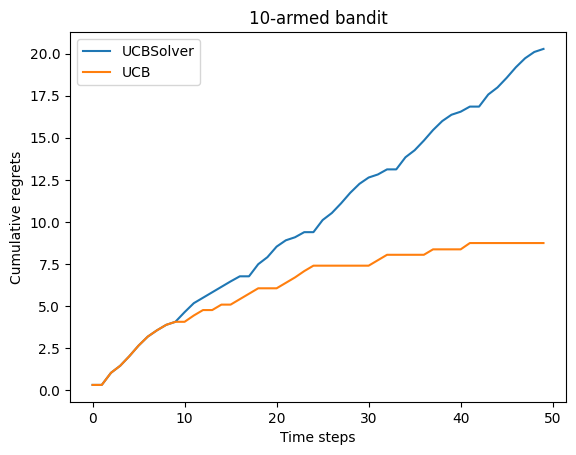

In [126]:
# solver1 = EpsilonGreedy(bandit_10_arm, epsilon=0.1)
# solver2 = DecayEpsilonGreedy(bandit_10_arm)
solver3 = UCBSolver(bandit_10_arm, c=1)
# solver4 = UCBSolver(bandit_10_arm, c=1)
solver5 = UCB(bandit_10_arm, coef=1)
# solvers = [solver1, solver2, solver3, solver4, solver5]
solvers = [solver3, solver5]
for s in solvers:
    s.run(50)
    print('算法的累积懊悔为：', s.regret)
# plot_results(solvers, ["ep", "decay_ep", "UCB,c=0.1", "UCB,c=1", "UCB"])
plot_results(solvers, ["UCBSolver", "UCB"])

# Tompson Sampling

In Tompson Sampling (TS), we assume the reward for each bandit follows a certain distribution, then we choose the bandit according to the expectation of each bandit. Whereas the computation cost of every distribution could be too expensive to accept, TS samples every action first, and choose the one with the largest reward. As you can see, TS is a Monte Carlo method.

But what distribution should we use for the estimation? Usually we use Beta distribution for our bandit problem. If a bandit is chosen for $k$ time, among which $m_1$ times we got reward 1 and $m_2$ times 0, then the reward of the bandit follows $$\beta(m_1+1, m_2+1)$$.

In [ ]:
class TSSolver(Solver):
    def __init__(self, bandit, init_prob = 1, alpha=None):
        super(TSSolver, self).__init__(bandit)
        self.alpha = alpha # step size in SMA, better to set when you are facing a nonstationary problem
        self.m1 = np.array([0] * self.bandit.K)
        self.m2 = np.array([0] * self.bandit.K)

    def sample_all(self):
        sampling_result = np.random.beta(self.m1+1, self.m2+1)
        return sampling_result


    def get_best_est(self):
        return np.argmax(self.sample_all()) # self.counts+1 to prevent div/0

    def run_one_step(self):
        # TODO: do one step
        # get a choice
        choice = self.get_best_est()
        
        # update estimates
        r = self.bandit.step(choice)
        if r == 1:
            self.m1[choice] += 1
        else:
            self.m2[choice] += 1

        return choice

算法的累积懊悔为： 178.35864150689588
算法的累积懊悔为： 87.41010240228648
算法的累积懊悔为： 202.84759282935016
算法的累积懊悔为： 30.350161551224883


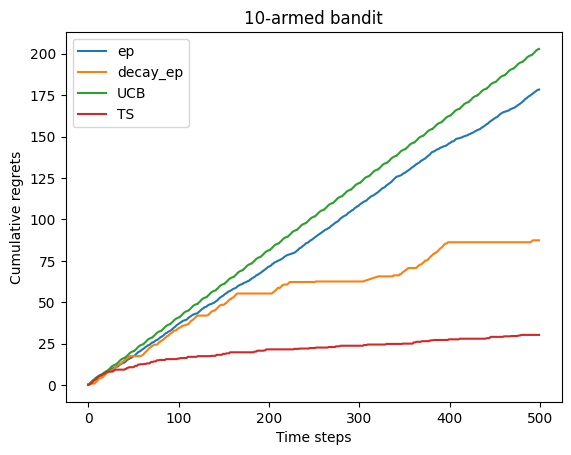

In [56]:
solver1 = EpsilonGreedy(bandit_10_arm, epsilon=0.1)
solver2 = DecayEpsilonGreedy(bandit_10_arm)
solver3 = UCBSolver(bandit_10_arm, p=0.001)
solver4 = TSSolver(bandit_10_arm)
solvers = [solver1, solver2, solver3, solver4]
for s in solvers:
    s.run(500)
    print('算法的累积懊悔为：', s.regret)
plot_results(solvers, ["ep", "decay_ep", "UCB", "TS"])